# **Projet NLP: Classification IA and Human Texts**

<ins>Group :</ins>
- Thomas Sinapi
- Pierre Derathe
- Manitas Bahri

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import gensim
import textdistance

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report
from pprint import pprint
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec

In [3]:
# nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kiba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
df = pd.read_csv("training.csv")
X, y = df["text"], df["generated"].astype("int")
df.shape

(4000, 2)

## 2. **<ins>Preprocessing</ins>**

In [30]:

pprint(X[0])

('Cars. Cars have been around since they became famous in the 1900s, when '
 'Henry Ford created and built the first ModelT. Cars have played a major role '
 'in our every day lives since then. But now, people are starting to question '
 'if limiting car usage would be a good thing. To me, limiting the use of cars '
 'might be a good thing to do.\n'
 '\n'
 'In like matter of this, article, "In German Suburb, Life Goes On Without '
 'Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of '
 'suburbs, where middle class families from either Shanghai or Chicago tend to '
 'make their homes. Experts say how this is a huge impediment to current '
 'efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are '
 'responsible for 12 percent of greenhouse gas emissions in Europe...and up to '
 '50 percent in some carintensive areas in the United States. Cars are the '
 'main reason for the greenhouse gas emissions because of a lot of people '
 'driving them a

In [31]:
def remove_tags(text):
    tags = ['\n', '\'']
    for tag in tags:
        text = text.replace(tag, '')
    
    return text


X = X.apply(remove_tags)

In [32]:
pprint(X[0])

('Cars. Cars have been around since they became famous in the 1900s, when '
 'Henry Ford created and built the first ModelT. Cars have played a major role '
 'in our every day lives since then. But now, people are starting to question '
 'if limiting car usage would be a good thing. To me, limiting the use of cars '
 'might be a good thing to do.In like matter of this, article, "In German '
 'Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how '
 'automobiles are the linchpin of suburbs, where middle class families from '
 'either Shanghai or Chicago tend to make their homes. Experts say how this is '
 'a huge impediment to current efforts to reduce greenhouse gas emissions from '
 'tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas '
 'emissions in Europe...and up to 50 percent in some carintensive areas in the '
 'United States. Cars are the main reason for the greenhouse gas emissions '
 'because of a lot of people driving them around all th

In [4]:
def remove_stopwords(tokens_list):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = np.empty_like(tokens_list)
    
    for i, tokens in enumerate(tokens_list):
        filtered_tokens[i] = [word for word in tokens if word.lower() not in stop_words]
    
    return pd.Series(filtered_tokens)

In [5]:
tokenizer = RegexpTokenizer(r'\w+')
X = X.apply(lambda x: tokenizer.tokenize(x.lower()))

In [6]:
X = remove_stopwords(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

### 2.1. <ins>TF-IDF</ins>

In [7]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train.apply(" ".join))
X_test_tfidf = tfidf.transform(X_test.apply(" ".join))

print("Number of words in vocabulary:", X_train_tfidf.shape[1])

In [23]:
tfidf.get_feature_names_out()

array(['00', '000', '001', ..., 'zoomed', 'zooming', 'zuckerburg'],
      dtype=object)

### 2.1. <ins>Word2Vec</ins>

In [8]:
word2vec = Word2Vec(X_train, window=5, min_count=10, workers=-1, vector_size=100)

In [9]:
def get_vector(text, model):
    vector = [0] * model.vector_size
    count = 0
    
    for word in text:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    
    if count != 0:
        vector = [x / count for x in vector]
    
    return vector

In [10]:
X_train_w2v = X_train.apply(lambda x: get_vector(x, word2vec)).values.tolist()
X_test_w2v = X_test.apply(lambda x: get_vector(x, word2vec)).values.tolist()

## 3. **<ins>Model Comparative *Multinomial NB* vs *Random Forest*<ins>**

Etudes comparatives de modèles de classification de textes avec TF-IDF et Word2Vec.

### 3.1 <ins>Multinomial Naive Bayes (TF-IDF)<ins>

In [11]:
mb = MultinomialNB()
y_cv = cross_val_predict(mb, X_train_tfidf, y_train, cv=5)

mb.fit(X_train_tfidf, y_train)
y_pred = mb.predict(X_test_tfidf)

print(f"(TF-IDF) Cross Validation Accuracy: {accuracy_score(y_train, y_cv):.3f}")

(TF-IDF) Cross Validation Accuracy: 0.954


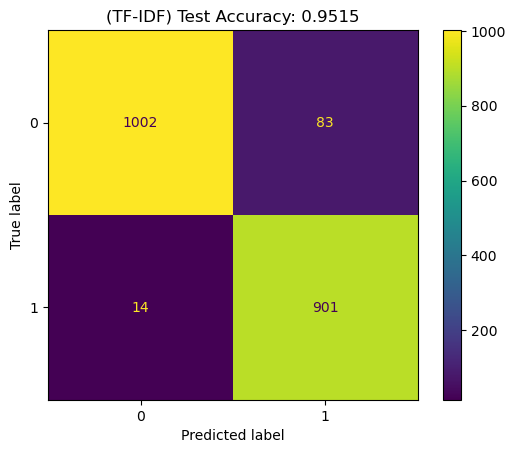

In [12]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_test)
plt.title(f"(TF-IDF) Test Accuracy: {accuracy_score(y_test, y_pred)}")
plt.show()

### 3.1.2 TF-IDF Hyper-parameter testing

In [22]:
# Create a pipeline with TF-IDF vectorizer and MultinomialNB classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

pipeline.fit(X_train, y_train)

AttributeError: 'list' object has no attribute 'lower'

In [ ]:

# Define the parameter grid to search
parameters = {
    'tfidf__max_features': [100, 1000, 3000, 10000, 20000],  # Adjust these values according to your needs
}

# Perform grid search
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

# Evaluate on the test set
y_pred = grid_search.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Get the results of grid search
results = grid_search.cv_results_

# Extract the mean test scores and standard deviations
mean_test_scores = results['mean_test_score']
std_test_scores = results['std_test_score']

# Get the values of the max_features parameter
max_features_values = parameters['tfidf__max_features']

# Plot accuracy with each parameter value
plt.errorbar(max_features_values, mean_test_scores, yerr=std_test_scores, fmt='-o')
plt.xlabel('max_features')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy with Different max_features')
plt.grid(True)
plt.show()

### 3.2 <ins>Multinomial Naive Bayes (Word2Vec)</ins>

In [13]:
mms = MinMaxScaler()
X_train_w2v_ss = mms.fit_transform(X_train_w2v)
X_test_w2v_ss = mms.transform(X_test_w2v)

In [14]:
mb = MultinomialNB()
y_cv = cross_val_predict(mb, X_train_w2v_ss, y_train, cv=5)

mb.fit(X_train_w2v_ss, y_train)
y_pred = mb.predict(X_test_w2v_ss)

print(f"(Word2Vec) Cross Validation Accuracy: {accuracy_score(y_train, y_cv):.3f}")

(Word2Vec) Cross Validation Accuracy: 0.869


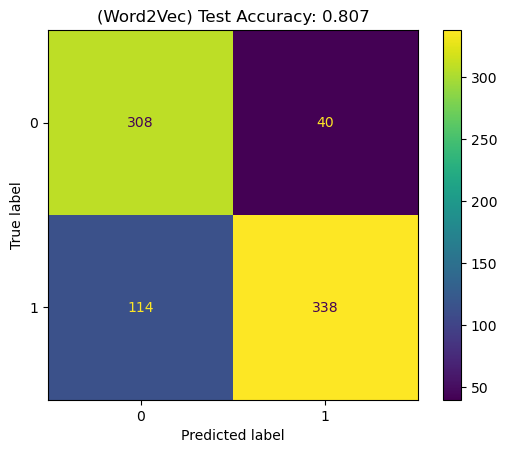

In [28]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_test)
plt.title(f"(Word2Vec) Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
plt.show()

### 3.3 <ins> Random Forest (TF-IDF)</ins>

In [29]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
y_cv = cross_val_predict(rf, X_train_tfidf, y_train, cv=5)

rf.fit(X_train_tfidf, y_train)
y_pred = rf.predict(X_test_tfidf)

print(f"(TF-IDF) Cross Validation Accuracy: {accuracy_score(y_train, y_cv):.3f}")

(TF-IDF) Cross Validation Accuracy: 0.985


### 3.4 <ins> Random Forest (Word2Vec)</ins>

In [30]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
y_cv = cross_val_predict(rf, X_train_w2v, y_train, cv=5)

rf.fit(X_train_w2v, y_train)
y_pred = rf.predict(X_test_w2v)

print(f"(Word2Vec) Cross Validation Accuracy: {accuracy_score(y_train, y_cv):.3f}")

(Word2Vec) Cross Validation Accuracy: 0.963


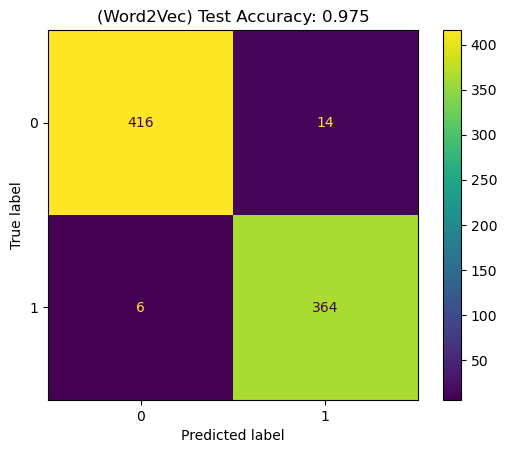

In [31]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_test)
plt.title(f"(Word2Vec) Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
plt.show()

### 3.4 bis <ins> Comparaison min_count avec Word2Vec</ins>

In [32]:
for min_count in range(1, 10):
    word2vec = Word2Vec(X_train, window=5, min_count=min_count, workers=-1, vector_size=100)
    X_train_w2v = X_train.apply(lambda x: get_vector(x, word2vec)).values.tolist()
    X_test_w2v = X_test.apply(lambda x: get_vector(x, word2vec)).values.tolist()
    
    rf = RandomForestClassifier(random_state=0, n_jobs=-1)
    y_cv = cross_val_predict(rf, X_train_w2v, y_train, cv=5)
    
    rf.fit(X_train_w2v, y_train)
    y_pred = rf.predict(X_test_w2v)
    
    print(f"Min Count: {min_count} - Cross Validation Accuracy: {accuracy_score(y_train, y_cv):.3f} - Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Min Count: 1 - Cross Validation Accuracy: 0.956 - Test Accuracy: 0.958
Min Count: 2 - Cross Validation Accuracy: 0.955 - Test Accuracy: 0.964
Min Count: 3 - Cross Validation Accuracy: 0.955 - Test Accuracy: 0.971
Min Count: 4 - Cross Validation Accuracy: 0.954 - Test Accuracy: 0.974
Min Count: 5 - Cross Validation Accuracy: 0.960 - Test Accuracy: 0.954
Min Count: 6 - Cross Validation Accuracy: 0.957 - Test Accuracy: 0.966
Min Count: 7 - Cross Validation Accuracy: 0.953 - Test Accuracy: 0.965
Min Count: 8 - Cross Validation Accuracy: 0.962 - Test Accuracy: 0.959
Min Count: 9 - Cross Validation Accuracy: 0.961 - Test Accuracy: 0.968
